# Import libraries

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

In [ ]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(5, 5, 5, 5), (4, 4, 4, 4)]
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(3, 3, 3, 3), (4, 4, 4, 4)]


# Policy network

## Network definition

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=2, action_space_dim=3)

## Exploration Policy

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
# Test if it works as expected
state = (0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 2
Q-VALUES: [-0.13723448  0.02612702  0.05741519]


### Softmax policy

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
state = (0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.13723448  0.02612702  0.05741519]


### Exploration profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

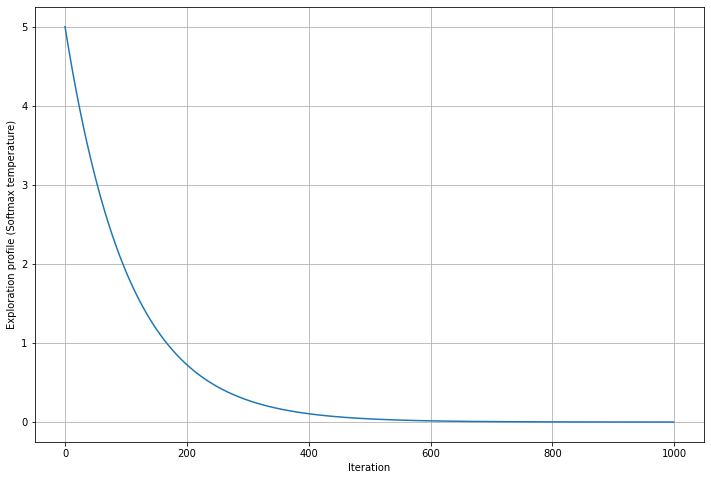

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Gym Environment (MountainCar-v0)

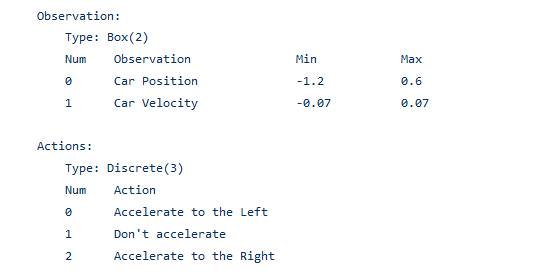

In [ ]:
### Create environment
env = gym.make('MountainCar-v0') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [ ]:
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10):     
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score 
    score = 0
    done = False
    # Go on until the score reach 200
    while not done and score < 200:
      # Choose a random action
      action = random.choice([0, 1, 2])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += 1
      # Set the current state for the next iteration
      state = next_state
      
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 


env.close()

EPISODE 1 - FINAL SCORE: 200
EPISODE 2 - FINAL SCORE: 200
EPISODE 3 - FINAL SCORE: 200
EPISODE 4 - FINAL SCORE: 200
EPISODE 5 - FINAL SCORE: 200
EPISODE 6 - FINAL SCORE: 200
EPISODE 7 - FINAL SCORE: 200
EPISODE 8 - FINAL SCORE: 200
EPISODE 9 - FINAL SCORE: 200
EPISODE 10 - FINAL SCORE: 200


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.0.15932.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.15932.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.15932.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.15932.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.15932.video000004.mp4



SHOWING VIDEO video/openaigym.video.0.15932.video000005.mp4



SHOWING VIDEO video/openaigym.video.0.15932.video000006.mp4



SHOWING VIDEO video/openaigym.video.0.15932.video000007.mp4



SHOWING VIDEO video/openaigym.video.0.15932.video000008.mp4



SHOWING VIDEO video/openaigym.video.0.15932.video000009.mp4


# Network update

## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.95   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-3   # Optimizer learning rate
target_net_update_steps = 8   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)
policy_net

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
target_net

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [ ]:
def update_step(policy_net, target_net, memory, gamma, optimizer, loss_fn, batch_size, PER=False, double=True):
        
    # Sample the data from the memory
    if PER == True:
      tree_idx, batch  = memory.sample(batch_size)
    else:
      batch = memory.sample(batch_size)
      batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states).cpu()

    if double == True:
      with torch.no_grad():
        policy_net.eval()
        q_values_next = policy_net(non_final_next_states)

      # Select the proper Q value for the corresponding action taken Q(s_t, a)
      state_action_values = q_values.gather(1, actions.unsqueeze(1))

      # Use policy network for selecting the action to take
      index = q_values_next.max(dim=1)[1]

      # Compute the value function of the next states using the target network V(s_{t+1}) = ( Q_target(s_{t+1}, arg max_a Q_policy(s_{t+1},a)) )
      with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
      next_state_max_q_values = torch.zeros(batch_size).unsqueeze(1)
      next_state_max_q_values[non_final_mask] = q_values_target.gather(1,index.unsqueeze(1))
    
      # Compute the expected Q values
      expected_state_action_values = rewards.unsqueeze(1) + (next_state_max_q_values * gamma)


    else:
      # Select the proper Q value for the corresponding action taken Q(s_t, a)
      state_action_values = q_values.gather(1, actions.unsqueeze(1))

      # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
      with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states).cpu()
      next_state_max_q_values = torch.zeros(batch_size)
      next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    
      # Compute the expected Q values
      expected_state_action_values = rewards + (next_state_max_q_values * gamma)
      expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

   
    if PER == True:
        absolute_errors = (torch.abs(state_action_values-next_state_max_q_values.unsqueeze(dim=1))).detach()   
        # Update priority
        memory.batch_update(tree_idx, absolute_errors)

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
results=[]
mean_results=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):
    tau = tau/5
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score
    score = 0
    done = False

    # Go on until the we reach 0.5 position or  200 iterations are reached
    while not done:
      
      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Modify reward       
      potential_weight = 2
      kinetic_weight = 400  
      reward = potential_weight*(abs(next_state[0]+0.6))+kinetic_weight*next_state[1]*next_state[1]

      # Update the final score (+1 for each step)
      score += 1

      # Apply reward 
      if done: 
          #reward += bad_state_penalty
          next_state = None
          if score<120:
            reward=reward+50

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    # Save the results
    results.append(score)
    mean_results.append(sum(results[-100:])/min(len(results),100))

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau} - MEAN RESULTS: {mean_results[-1]}") # Print the final score
    

env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 200 - Temperature: 1.0 - MEAN RESULTS: 200.0
EPISODE: 2 - FINAL SCORE: 200 - Temperature: 0.9903898480332908 - MEAN RESULTS: 200.0
EPISODE: 3 - FINAL SCORE: 200 - Temperature: 0.9808720510874048 - MEAN RESULTS: 200.0
EPISODE: 4 - FINAL SCORE: 200 - Temperature: 0.9714457216165571 - MEAN RESULTS: 200.0
EPISODE: 5 - FINAL SCORE: 200 - Temperature: 0.9621099806044124 - MEAN RESULTS: 200.0
EPISODE: 6 - FINAL SCORE: 200 - Temperature: 0.9528639574821163 - MEAN RESULTS: 200.0
EPISODE: 7 - FINAL SCORE: 200 - Temperature: 0.9437067900471133 - MEAN RESULTS: 200.0
EPISODE: 8 - FINAL SCORE: 200 - Temperature: 0.9346376243827452 - MEAN RESULTS: 200.0
Updating target network...
EPISODE: 9 - FINAL SCORE: 200 - Temperature: 0.9256556147786229 - MEAN RESULTS: 200.0
EPISODE: 10 - FINAL SCORE: 200 - Temperature: 0.9167599236517626 - MEAN RESULTS: 200.0
EPISODE: 11 - FINAL SCORE: 200 - Temperature: 0.9079497214684805 - MEAN RESULTS: 200.0
EPISODE: 12 -

In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.1.15932.video000000.mp4



SHOWING VIDEO video/openaigym.video.1.15932.video000100.mp4



SHOWING VIDEO video/openaigym.video.1.15932.video000200.mp4



SHOWING VIDEO video/openaigym.video.1.15932.video000300.mp4



SHOWING VIDEO video/openaigym.video.1.15932.video000400.mp4



SHOWING VIDEO video/openaigym.video.1.15932.video000500.mp4



SHOWING VIDEO video/openaigym.video.1.15932.video000600.mp4



SHOWING VIDEO video/openaigym.video.1.15932.video000700.mp4



SHOWING VIDEO video/openaigym.video.1.15932.video000800.mp4



SHOWING VIDEO video/openaigym.video.1.15932.video000900.mp4


### Show results

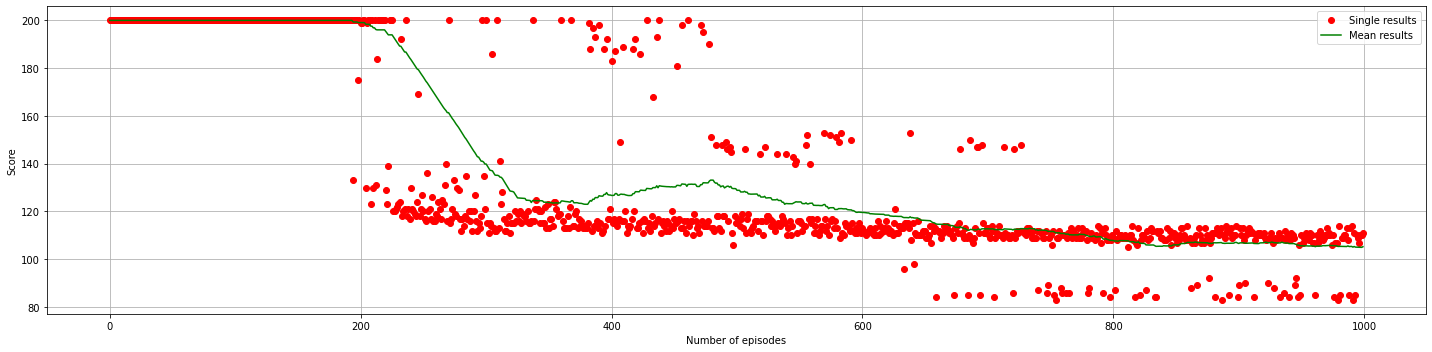

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(range(len(results)),results, marker="o", color="red", linestyle="", label='Single results')
plt.plot(mean_results, color="green",label='Mean results')
plt.xlabel("Number of episodes")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score.
    score = 0
    done = False
    # Go on until the we reach 0.5 position or  200 iterations are reached
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += 1 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 106
EPISODE 2 - FINAL SCORE: 109
EPISODE 3 - FINAL SCORE: 111
EPISODE 4 - FINAL SCORE: 111
EPISODE 5 - FINAL SCORE: 107
EPISODE 6 - FINAL SCORE: 109
EPISODE 7 - FINAL SCORE: 109
EPISODE 8 - FINAL SCORE: 109
EPISODE 9 - FINAL SCORE: 108
EPISODE 10 - FINAL SCORE: 110


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.2.15932.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.15932.video000001.mp4



SHOWING VIDEO video/openaigym.video.2.15932.video000002.mp4



SHOWING VIDEO video/openaigym.video.2.15932.video000003.mp4



SHOWING VIDEO video/openaigym.video.2.15932.video000004.mp4



SHOWING VIDEO video/openaigym.video.2.15932.video000005.mp4



SHOWING VIDEO video/openaigym.video.2.15932.video000006.mp4



SHOWING VIDEO video/openaigym.video.2.15932.video000007.mp4



SHOWING VIDEO video/openaigym.video.2.15932.video000008.mp4



SHOWING VIDEO video/openaigym.video.2.15932.video000009.mp4
